<a href="https://colab.research.google.com/github/SABLISTER/Hi_friend/blob/main/Synapse_Detective.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Synapse Detective  
Interactive neuron explorer  
Created by **Michael House**  
Montclair State University / Princeton SURFiN Fellow  
[CV / Contact](http://www.MichaelHouse.cv)  

_Enter a neuron number and reveal its activity profile, spatial context, and top connections._  
This tool supports memory circuit analysis from two-photon data with a little flair.

---

💡 Maintained on [GitHub](https://github.com/SABLISTER/Hi_friend) | Reach out if it breaks

d74.mat already exists. Skipping download.
Loading data for session 74...
Data loaded successfully!


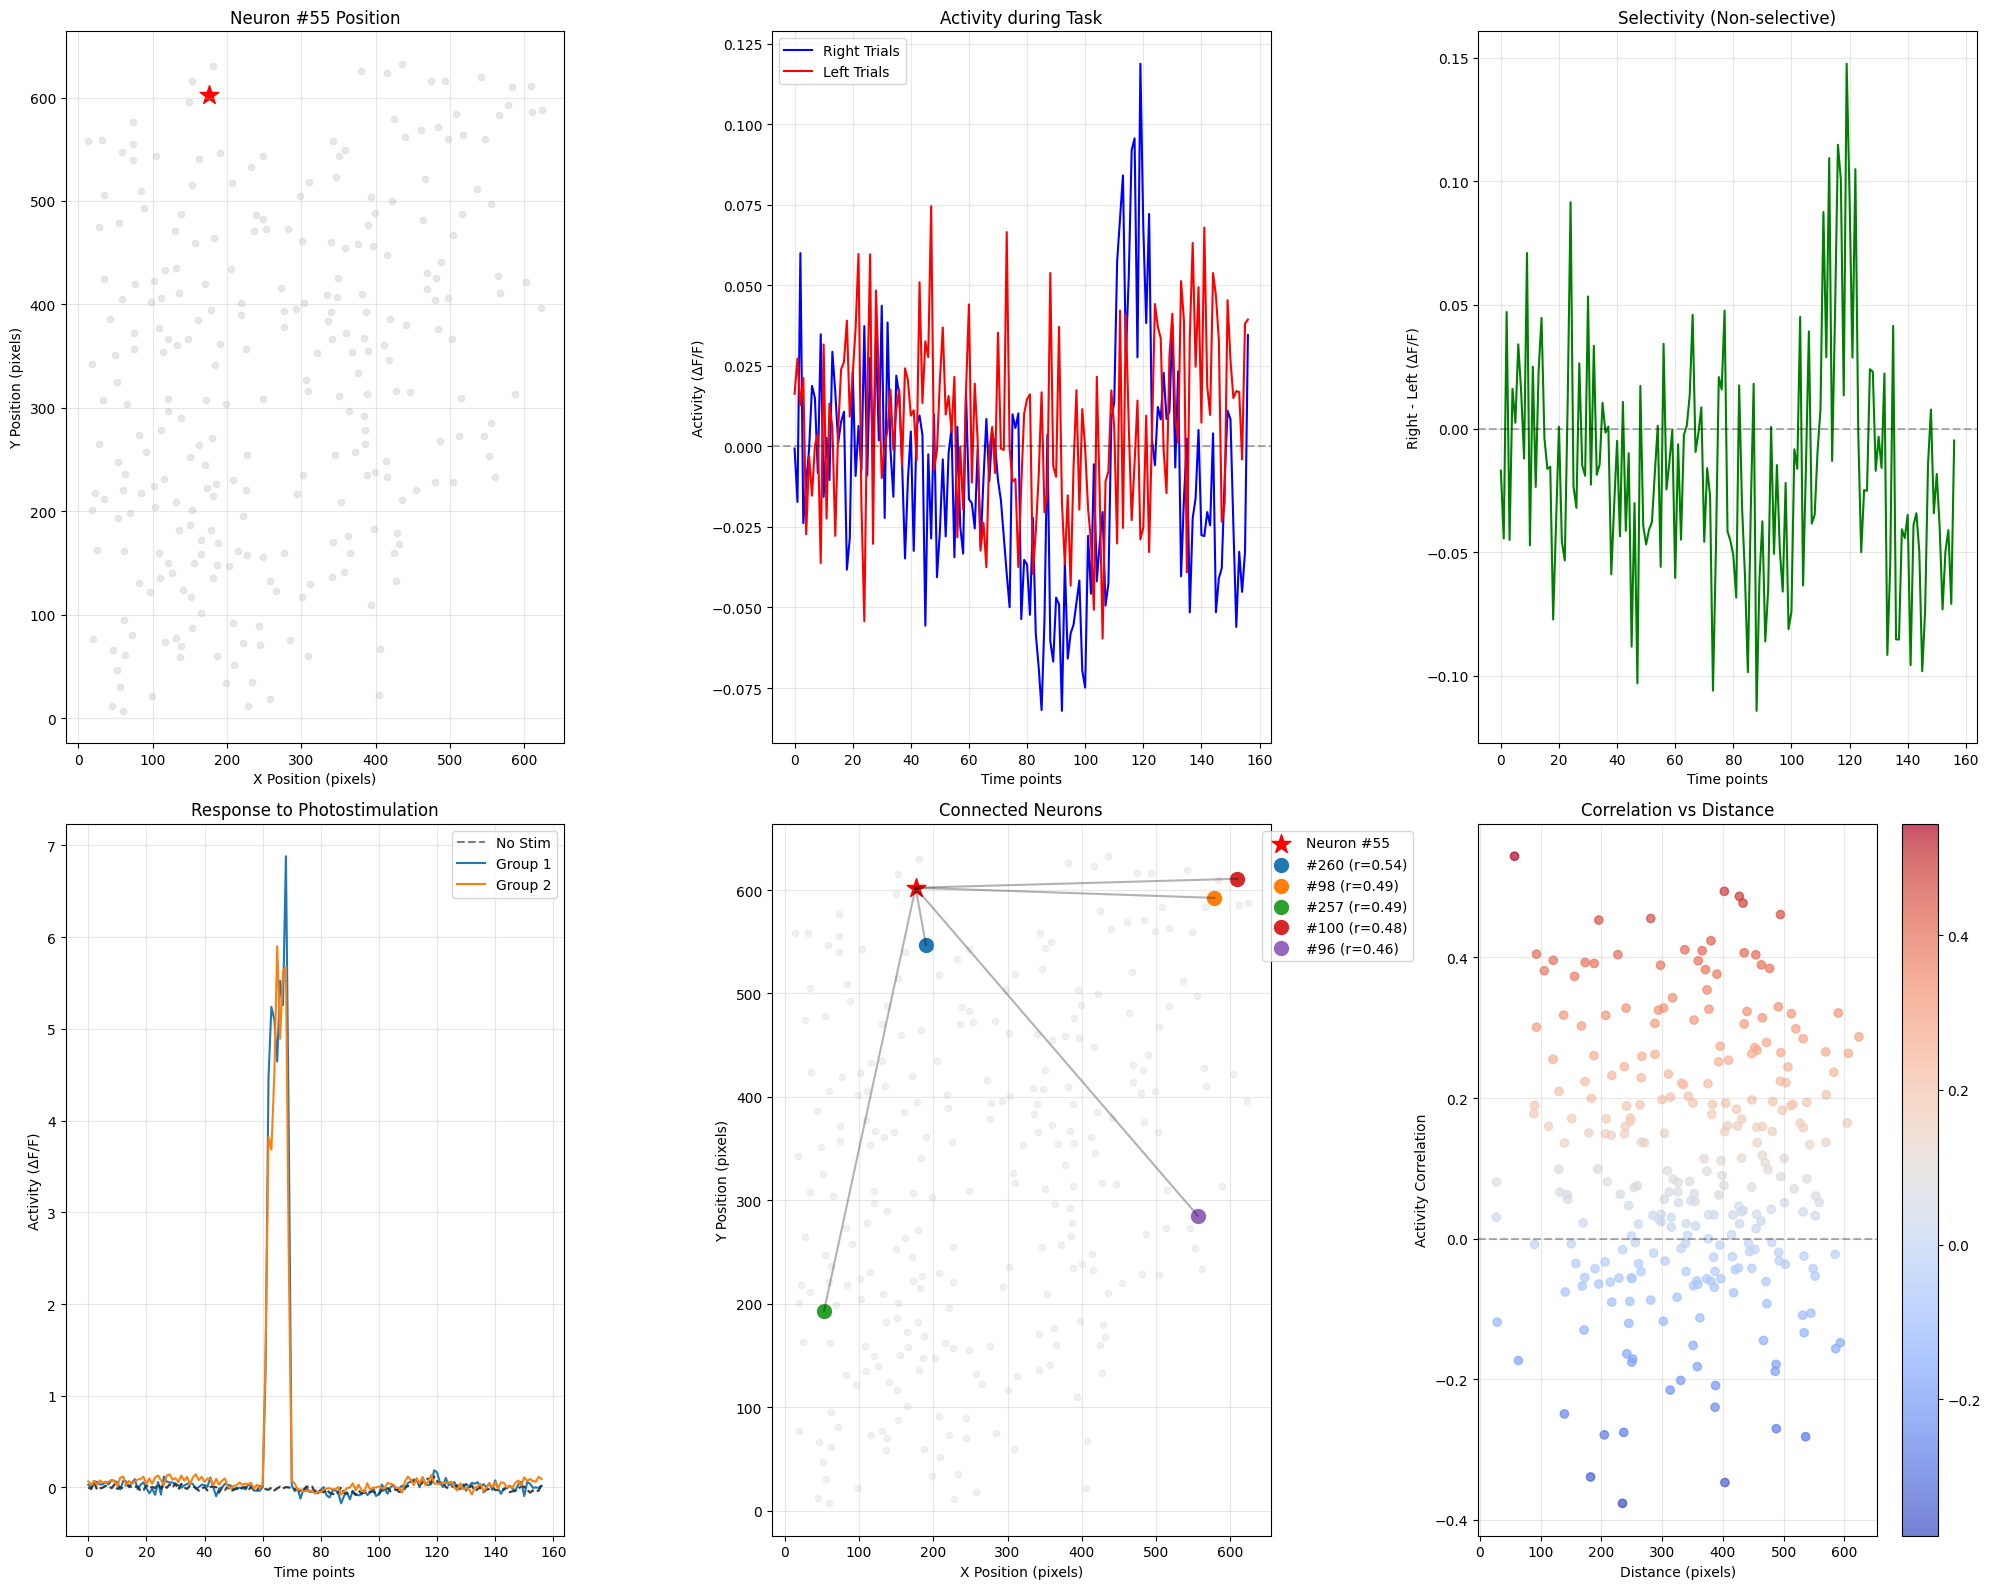


===== NEURON #55 SUMMARY =====
Position: X=176.2, Y=602.2
Selectivity: Non-selective (strength: 0.015)

Photostimulation Responses:
  Group 1: Peak response = 0.056 (non-target)
  Group 2: Peak response = 0.064 (non-target)

Top Connected Neurons:
  #260: r=0.544, distance=57.2 pixels
  #98: r=0.494, distance=402.4 pixels
  #257: r=0.487, distance=427.1 pixels
  #100: r=0.477, distance=433.2 pixels
  #96: r=0.461, distance=494.8 pixels



===== NEURON #55 SUMMARY =====

- **Position**: X=176.2, Y=602.2
- **Selectivity**: Non-selective (strength: 0.015)

**Photostimulation Responses:**
  - Group 1: Peak response = 0.056 (non-target)
  - Group 2: Peak response = 0.064 (non-target)

**Top Connected Neurons:**
  - #260: r=0.544, distance=57.2 pixels
  - #98: r=0.494, distance=402.4 pixels
  - #257: r=0.487, distance=427.1 pixels
  - #100: r=0.477, distance=433.2 pixels
  - #96: r=0.461, distance=494.8 pixels


In [21]:
# @title # Type in a neuron number (0–257), hit the play button on the left, then scroll down to see its activity, connections, and more.  vvvv
from re import S
# from google.colab import drive
# drive.mount('/content/drive')
# Install necessary package
from IPython.core.display import display, HTML

display(HTML("<style>.output_wrapper, .output {height:auto !important; max-height:1500px;}</style>"))
import os

from IPython.display import Markdown, display
filename = "d74.mat"
url = "https://osf.io/qux3j/download"
if not os.path.isfile(filename):
    print(f"{filename} not found. Downloading...")
    !wget {url} -O {filename}
else:
    print(f"{filename} already exists. Skipping download.")

!pip install mat73
import numpy as np
import mat73
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import os
d = mat73.loadmat(f"/content/d74.mat")
epochs = d['epochs']
dt_si = d['dt_si']
distance = d['distance']
stimXY = d['stimXY']
XY = d['XY']
CL = d['CL']
CR = d['CR']
L = d['L']
R = d['R']

neuron_id = 23
neuron_id = 55
neuron_id = 55 # @param {"type":"number","placeholder":"45678"}

def neuron_decoder(session_id=74, neuron_id=None):
    # Load the data
    try:
        print(f"Loading data for session {session_id}...")
        d = mat73.loadmat(f"/content/d{session_id}.mat")
        print("Data loaded successfully!")
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

    # Get total number of neurons
    total_neurons = d['XY'].shape[0]

    if neuron_id is None:
        print(f"Please specify a neuron ID between 0 and {total_neurons-1}")
        return None

    if neuron_id >= total_neurons or neuron_id < 0:
        print(f"Invalid neuron ID. Must be between 0 and {total_neurons-1}")
        return None

    # Extract all available information about the neuron
    neuron_info = {}

    # Basic information
    neuron_info['id'] = neuron_id
    neuron_info['position'] = d['XY'][neuron_id]

    # Analyze selectivity (right vs left trials)
    try:
        # Calculate average activity in non-photostimulation trials
        right_activity = np.mean(d['R'][0][:, neuron_id, :], axis=1)  # Average across trials
        left_activity = np.mean(d['L'][0][:, neuron_id, :], axis=1)   # Average across trials

        # Calculate selectivity (difference between right and left trials)
        selectivity = right_activity - left_activity
        neuron_info['selectivity'] = selectivity

        # Determine if neuron is right-selective, left-selective, or mixed
        late_delay_idx = int(len(selectivity) * 0.8)  # Approximate index for late delay period
        delay_selectivity = np.mean(selectivity[late_delay_idx-5:late_delay_idx+5])

        if delay_selectivity > 0.05:
            neuron_info['preference'] = 'Right-selective'
            neuron_info['selectivity_strength'] = delay_selectivity
        elif delay_selectivity < -0.05:
            neuron_info['preference'] = 'Left-selective'
            neuron_info['selectivity_strength'] = -delay_selectivity
        else:
            neuron_info['preference'] = 'Non-selective'
            neuron_info['selectivity_strength'] = abs(delay_selectivity)
    except:
        print("Could not analyze selectivity")

    # Analyze responses to photostimulation
    stim_responses = []
    try:
        # Number of photostimulation groups
        num_pg = len(d['R']) - 1  # Subtract 1 for non-photostim condition

        for pg in range(1, num_pg + 1):
            # Measure average activity during photostim vs non-photostim
            non_photostim_activity = np.mean(d['R'][0][:, neuron_id, :], axis=1)
            photostim_activity = np.mean(d['R'][pg][:, neuron_id, :], axis=1)

            # Calculate response to photostimulation
            photostim_response = photostim_activity - non_photostim_activity

            # Find peak response
            post_stim_idx = len(photostim_response) // 2  # Approximate index for post-stimulation
            peak_response = np.max(photostim_response[post_stim_idx:post_stim_idx+10])

            # Check if this was a target for photostimulation
            is_target = False
            try:
                stim_targets = d['stimXY'][pg-1]
                target_distances = np.sqrt(np.sum((stim_targets - neuron_info['position'])**2, axis=1))
                if np.min(target_distances) < 20:  # Within 20 pixels of a stim target
                    is_target = True
            except:
                pass

            stim_responses.append({
                'group': pg,
                'peak_response': peak_response,
                'is_target': is_target
            })

        neuron_info['photostim_responses'] = stim_responses
    except:
        print("Could not analyze photostimulation responses")

    # Find potentially connected neurons (correlation analysis)
    try:
        connected_neurons = []

        # Get activity traces for all neurons
        all_activity = np.zeros((total_neurons, d['R'][0].shape[0]))
        for n in range(total_neurons):
            all_activity[n, :] = np.mean(d['R'][0][:, n, :], axis=1)

        # Calculate correlation with all other neurons
        target_activity = all_activity[neuron_id, :]
        for n in range(total_neurons):
            if n == neuron_id:
                continue

            corr, p_value = pearsonr(target_activity, all_activity[n, :])

            # Calculate distance
            distance = np.sqrt(np.sum((d['XY'][n] - neuron_info['position'])**2))

            if abs(corr) > 0.3 and p_value < 0.05:  # Threshold for significance
                connected_neurons.append({
                    'neuron_id': n,
                    'correlation': corr,
                    'p_value': p_value,
                    'distance': distance,
                    'position': d['XY'][n]
                })

        # Sort by correlation strength
        connected_neurons = sorted(connected_neurons, key=lambda x: abs(x['correlation']), reverse=True)
        neuron_info['connected_neurons'] = connected_neurons[:10]  # Top 10 connections
    except:
        print("Could not analyze neuron connections")

     # Display neuron information
    display_neuron_info(d, neuron_info)

    return neuron_info

    # @title Neuron Decoder {"run":"auto","vertical-output":true,"display-mode":"form"}
neuron_id = 55
session = 74 # @param {"type":"number","placeholder":"74"}

def display_neuron_info(d, neuron_info):
    """Display comprehensive information about the neuron"""

    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))

    # Plot 1: Position in the field of view
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.scatter(d['XY'][:, 0], d['XY'][:, 1], c='lightgray', alpha=0.5, s=20)
    ax1.scatter(neuron_info['position'][0], neuron_info['position'][1], c='red', s=200, marker='*')
    ax1.set_title(f"Neuron #{neuron_info['id']} Position")
    ax1.set_xlabel("X Position (pixels)")
    ax1.set_ylabel("Y Position (pixels)")
    ax1.grid(True, alpha=0.3)

    # Plot 2: Activity traces
    ax2 = fig.add_subplot(2, 3, 2)
    if 'selectivity' in neuron_info:
        time_points = np.arange(len(neuron_info['selectivity']))
        ax2.plot(time_points, np.mean(d['R'][0][:, neuron_info['id'], :], axis=1), 'b-', label='Right Trials')
        ax2.plot(time_points, np.mean(d['L'][0][:, neuron_info['id'], :], axis=1), 'r-', label='Left Trials')
        ax2.set_title("Activity during Task")
        ax2.set_xlabel("Time points")
        ax2.set_ylabel("Activity (ΔF/F)")
        ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    # Plot 3: Selectivity
    ax3 = fig.add_subplot(2, 3, 3)
    if 'selectivity' in neuron_info:
        time_points = np.arange(len(neuron_info['selectivity']))
        ax3.plot(time_points, neuron_info['selectivity'], 'g-')
        ax3.set_title(f"Selectivity ({neuron_info.get('preference', 'Unknown')})")
        ax3.set_xlabel("Time points")
        ax3.set_ylabel("Right - Left (ΔF/F)")
        ax3.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        ax3.grid(True, alpha=0.3)

    # Plot 4: Response to photostimulation
    ax4 = fig.add_subplot(2, 3, 4)
    if 'photostim_responses' in neuron_info and len(neuron_info['photostim_responses']) > 0:
        for resp in neuron_info['photostim_responses'][:3]:  # Show first 3 responses
            pg = resp['group']

            # Plot activity with and without photostimulation
            time_points = np.arange(len(np.mean(d['R'][0][:, neuron_info['id'], :], axis=1)))
            ax4.plot(time_points, np.mean(d['R'][0][:, neuron_info['id'], :], axis=1), 'k--', alpha=0.5, label='No Stim' if pg == 1 else None)
            ax4.plot(time_points, np.mean(d['R'][pg][:, neuron_info['id'], :], axis=1), label=f'Group {pg}')

        ax4.set_title("Response to Photostimulation")
        ax4.set_xlabel("Time points")
        ax4.set_ylabel("Activity (ΔF/F)")
        ax4.legend()
        ax4.grid(True, alpha=0.3)

    # Plot 5: Connected neurons
    ax5 = fig.add_subplot(2, 3, 5)
    if 'connected_neurons' in neuron_info and len(neuron_info['connected_neurons']) > 0:
        # Plot all neurons
        ax5.scatter(d['XY'][:, 0], d['XY'][:, 1], c='lightgray', alpha=0.3, s=20)

        # Plot target neuron
        ax5.scatter(neuron_info['position'][0], neuron_info['position'][1], c='red', s=200, marker='*', label=f'Neuron #{neuron_info["id"]}')

        # Plot connected neurons
        for i, conn in enumerate(neuron_info['connected_neurons'][:5]):  # Top 5 connections
            ax5.scatter(conn['position'][0], conn['position'][1], s=100, label=f'#{conn["neuron_id"]} (r={conn["correlation"]:.2f})')

            # Draw connection line
            ax5.plot([neuron_info['position'][0], conn['position'][0]],
                    [neuron_info['position'][1], conn['position'][1]],
                    'k-', alpha=0.3)

        ax5.set_title("Connected Neurons")
        ax5.set_xlabel("X Position (pixels)")
        ax5.set_ylabel("Y Position (pixels)")
        ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
        ax5.grid(True, alpha=0.3)

    # Plot 6: Correlation vs Distance for all neurons
    ax6 = fig.add_subplot(2, 3, 6)
    if 'connected_neurons' in neuron_info and len(neuron_info['connected_neurons']) > 0:
        # Calculate correlation and distance for all neurons
        all_corrs = []
        all_dists = []
        all_neurons = []

        # Get activity traces for all neurons
        all_activity = np.zeros((d['XY'].shape[0], d['R'][0].shape[0]))
        for n in range(d['XY'].shape[0]):
            all_activity[n, :] = np.mean(d['R'][0][:, n, :], axis=1)

        # Calculate correlation with all other neurons
        target_activity = all_activity[neuron_info['id'], :]
        for n in range(d['XY'].shape[0]):
            if n == neuron_info['id']:
                continue

            corr, _ = pearsonr(target_activity, all_activity[n, :])

            # Calculate distance
            distance = np.sqrt(np.sum((d['XY'][n] - neuron_info['position'])**2))

            all_corrs.append(corr)
            all_dists.append(distance)
            all_neurons.append(n)

        # Plot correlation vs distance
        sc = ax6.scatter(all_dists, all_corrs, c=all_corrs, cmap='coolwarm', alpha=0.7)
        ax6.set_title("Correlation vs Distance")
        ax6.set_xlabel("Distance (pixels)")
        ax6.set_ylabel("Activity Correlation")
        ax6.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        ax6.grid(True, alpha=0.3)
        plt.colorbar(sc, ax=ax6)

    plt.tight_layout()
    plt.show()

    # Display text summary
    print(f"\n===== NEURON #{neuron_info['id']} SUMMARY =====")
    print(f"Position: X={neuron_info['position'][0]:.1f}, Y={neuron_info['position'][1]:.1f}")

    if 'preference' in neuron_info:
        print(f"Selectivity: {neuron_info['preference']} (strength: {neuron_info['selectivity_strength']:.3f})")

    if 'photostim_responses' in neuron_info:
        print("\nPhotostimulation Responses:")
        for resp in neuron_info['photostim_responses']:
            target_status = "TARGET" if resp['is_target'] else "non-target"
            print(f"  Group {resp['group']}: Peak response = {resp['peak_response']:.3f} ({target_status})")

    if 'connected_neurons' in neuron_info and len(neuron_info['connected_neurons']) > 0:
        print("\nTop Connected Neurons:")
        for i, conn in enumerate(neuron_info['connected_neurons'][:5]):
            print(f"  #{conn['neuron_id']}: r={conn['correlation']:.3f}, distance={conn['distance']:.1f} pixels")

neuron_info = neuron_decoder(session_id=session, neuron_id=neuron_id)
# Decode the neuron

# Display nicely formatted summary
display(Markdown(format_summary(neuron_info)))

